In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   

# Suppress df assignment warning
pd.options.mode.chained_assignment = None  

# Define file paths
ais_tracks_path = '../data/tracks_ais.csv'
radar_tracks_path = '../data/tracks_radar.csv'
radar_detections_path = '../data/detections_radar.csv'
tagged_detections_path = '../data/detections_tagged.csv'
tracks_tagged_path = '../data/tracks_tagged.csv'

ais_tracks = pd.read_csv(ais_tracks_path)
radar_tracks = pd.read_csv(radar_tracks_path)
radar_detections = pd.read_csv(radar_detections_path)
tagged_detections = pd.read_csv(tagged_detections_path)
tracks_tagged = pd.read_csv(tracks_tagged_path)

del ais_tracks_path, radar_tracks_path, radar_detections_path, tagged_detections_path, tracks_tagged_path

In [3]:
ais_tracks['type_m2'].value_counts()

type_m2
cargo_ship                 10263
class_b                     4795
passenger_ship              3902
other                       2863
tanker_ship                 1411
tug                         1176
military_ship                951
towing_ship                  779
pleasure_craft               557
commercial_fishing_boat      292
search_and_rescue_boat       178
unknown                       82
sailboat                      70
law_enforcement_boat          55
high_speed_craft              40
pilot_boat                     2
Name: count, dtype: int64

In [ ]:
# Merge radar_detections with ais_tracks using inner join
merged_radar_detections = radar_detections.merge(
    ais_tracks[['id_track', 'type_m2', 'dim_a', 'dim_b', 'dim_c', 'dim_d']],  # Only include id_track and type_m2 from ais_tracks
    left_on='assoc_id',  # Use assoc_id from radar_detections
    right_on='id_track',  # Match with id_track from ais_tracks
    how='inner'  # Only keep matched entries
)

merged_radar_detections = merged_radar_detections.drop('id_track_x', axis=1)
merged_radar_detections = merged_radar_detections.rename(columns={'id_track_y': 'id_track'})

print("Original radar_detections shape:", radar_detections.shape)
print("Merged dataset shape:", merged_radar_detections.shape)
print("\nNumber of matched entries:", len(merged_radar_detections))
print("Number of unmatched radar detections:", len(radar_detections) - len(merged_radar_detections))
print("\nNumber of total radar tracks:", len(np.unique(ais_tracks['id_track'])))
print("\nNumber of tracks overlapped with AIS:", len(np.unique(merged_radar_detections['id_track'])))

Original radar_detections shape: (7387790, 14)
Merged dataset shape: (6770279, 19)

Number of matched entries: 6770279
Number of unmatched radar detections: 617511

Number of total radar tracks: 27416

Number of tracks overlapped with AIS: 15345


In [56]:
def plot_trajectory(type, num_samples = 6, merged_radar_detections = merged_radar_detections):
    """
    Args: 
        type: vessel type of interest
        num_samples: number of random trajectories to be plotted

    Plot trajectories of vessel of type based on radar detections
    """
    assert type in merged_radar_detections['type_m2'].unique(), "type must be a valid type"

    df = merged_radar_detections[merged_radar_detections['type_m2'] == type]
    df.loc[:, 'datetime'] = df['cdate'] + ' ' + df['ctime']
    track_ids = df['id_track'].unique()
    sampled_tracks = np.random.choice(track_ids, size = num_samples, replace = False)

    # Create subplot grid
    n_rows = num_samples // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(20, 6*n_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Add main title
    fig.suptitle(f"{type}", fontsize=40, y=1.02)

    # Plot each trajectory
    for idx, track_id in enumerate(sampled_tracks):
        track_data = df[df['id_track'] == track_id].sort_values('datetime')
        
        # Calculate duration
        start_time = pd.to_datetime(track_data['ctime'].iloc[0], format='%H:%M:%S')
        end_time = pd.to_datetime(track_data['ctime'].iloc[-1], format='%H:%M:%S')
        duration = end_time - start_time
        hours = duration.components.hours
        minutes = duration.components.minutes
        seconds = duration.components.seconds
        duration_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        
        # Plot trajectory
        axes[idx].plot(track_data['longitude'], track_data['latitude'], 
                      marker='o', markersize=2, linewidth=1, alpha=0.6)
        
        # Add start and end points
        axes[idx].scatter(track_data['longitude'].iloc[0], track_data['latitude'].iloc[0], 
                         color='green', marker='^', s=100, label='Start')
        axes[idx].scatter(track_data['longitude'].iloc[-1], track_data['latitude'].iloc[-1], 
                         color='red', marker='v', s=100, label='End')
        
        # Customize subplot
        axes[idx].set_title(f'Track {track_id}\nDuration: {duration_str}')
        axes[idx].set_xlabel('Longitude')
        axes[idx].set_ylabel('Latitude')
        axes[idx].grid(True)
        axes[idx].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    # # Print information about each track
    # print(f"\nTrajectory Information for {type}:")
    # for track_id in sampled_tracks:
    #     track_data = df[df['id_track'] == track_id]
    #     start_time = pd.to_datetime(track_data['ctime'].iloc[0], format='%H:%M:%S')
    #     end_time = pd.to_datetime(track_data['ctime'].iloc[-1], format='%H:%M:%S')
    #     duration = end_time - start_time
        
    #     print(f"\nTrack {track_id}:")
    #     print(f"Number of points: {len(track_data)}")
    #     print(f"Duration: {duration}")
    #     print(f"Start time: {start_time.strftime('%H:%M:%S')}")
    #     print(f"End time: {end_time.strftime('%H:%M:%S')}")

### Explore Trajectories of Different Vessel Types

In [57]:
ais_tracks['type_m2'].value_counts()

type_m2
cargo_ship                 10263
class_b                     4795
passenger_ship              3902
other                       2863
tanker_ship                 1411
tug                         1176
military_ship                951
towing_ship                  779
pleasure_craft               557
commercial_fishing_boat      292
search_and_rescue_boat       178
unknown                       82
sailboat                      70
law_enforcement_boat          55
high_speed_craft              40
pilot_boat                     2
Name: count, dtype: int64

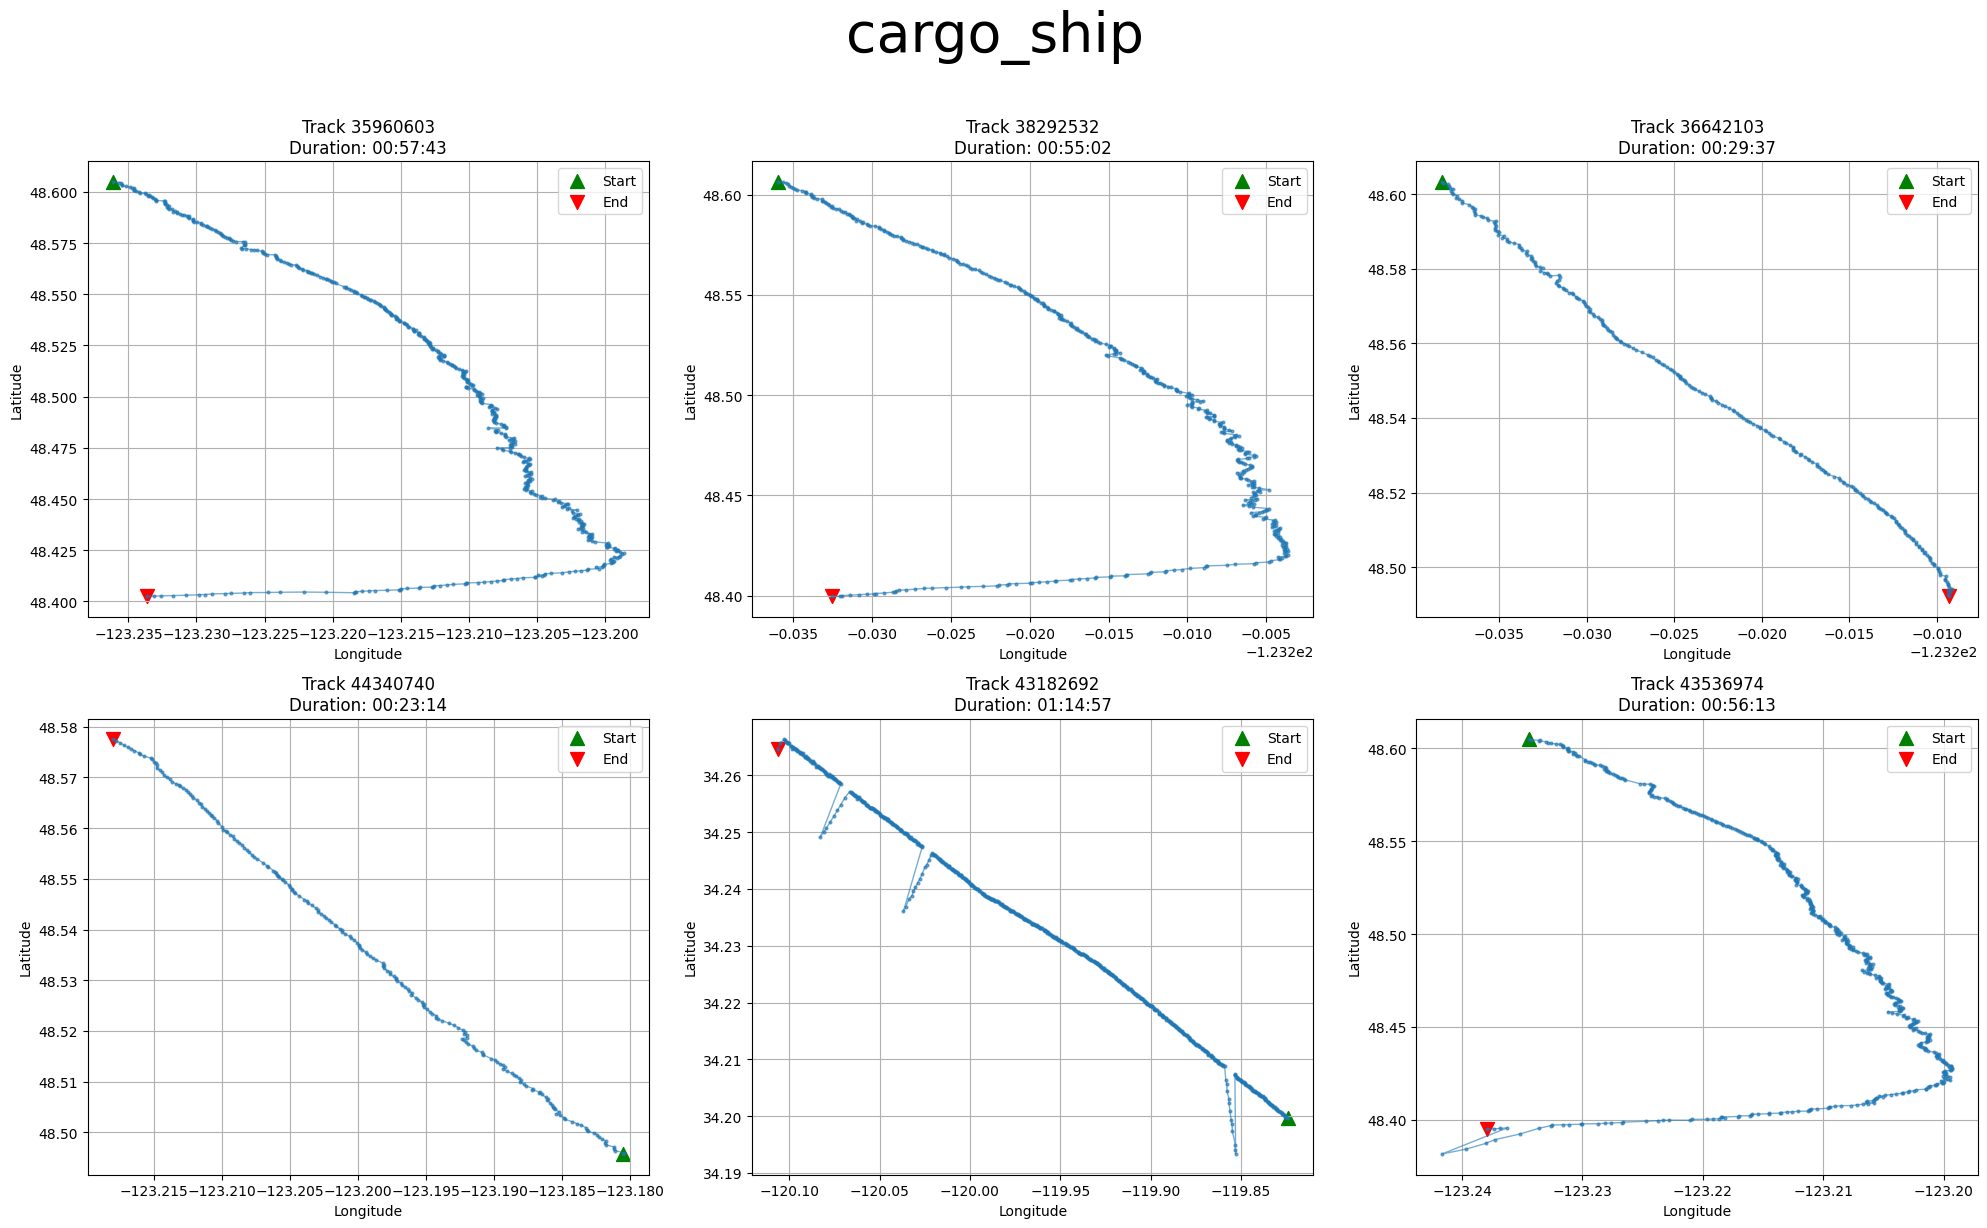

In [58]:
plot_trajectory('cargo_ship')

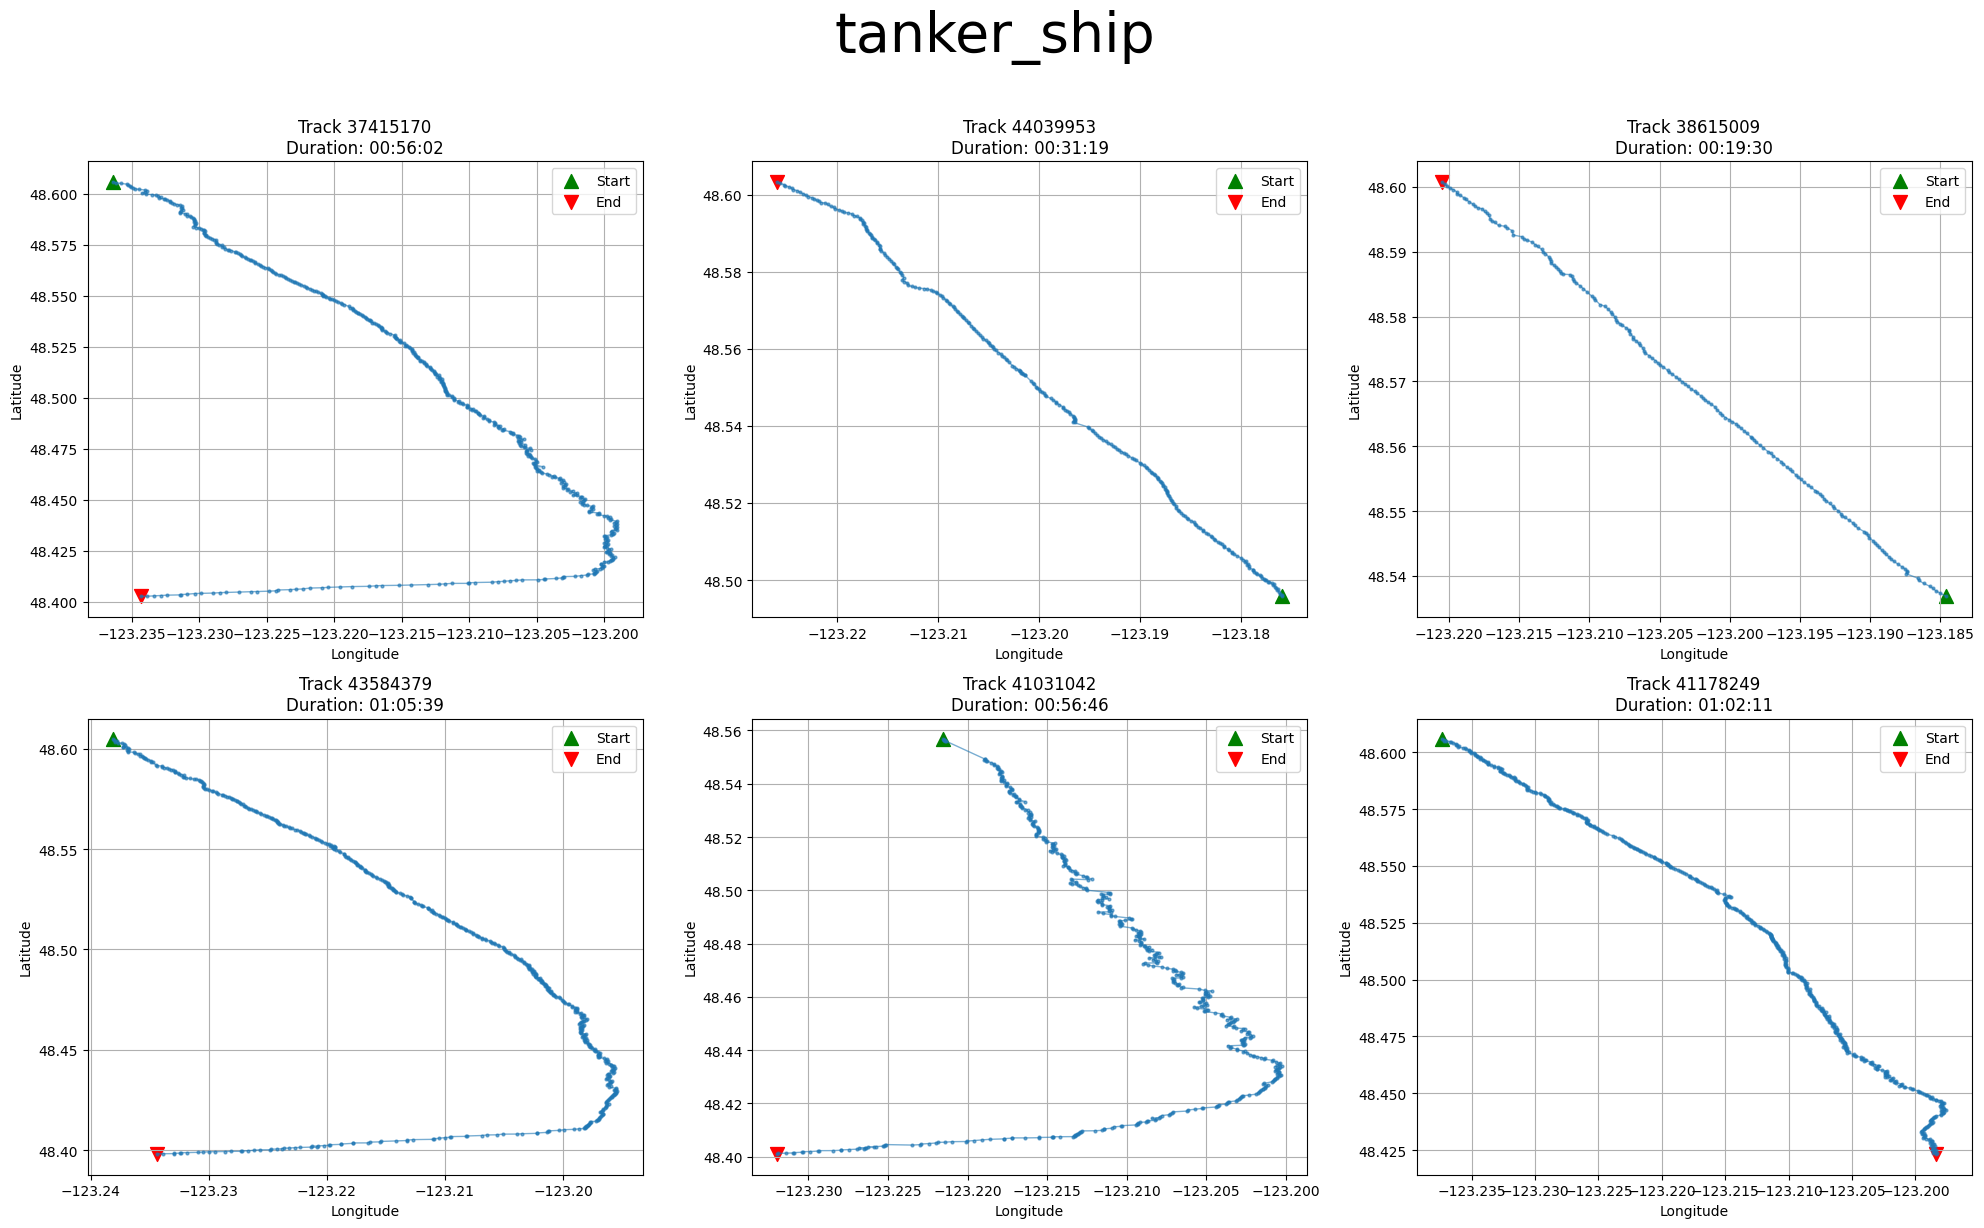

In [59]:
plot_trajectory('tanker_ship')

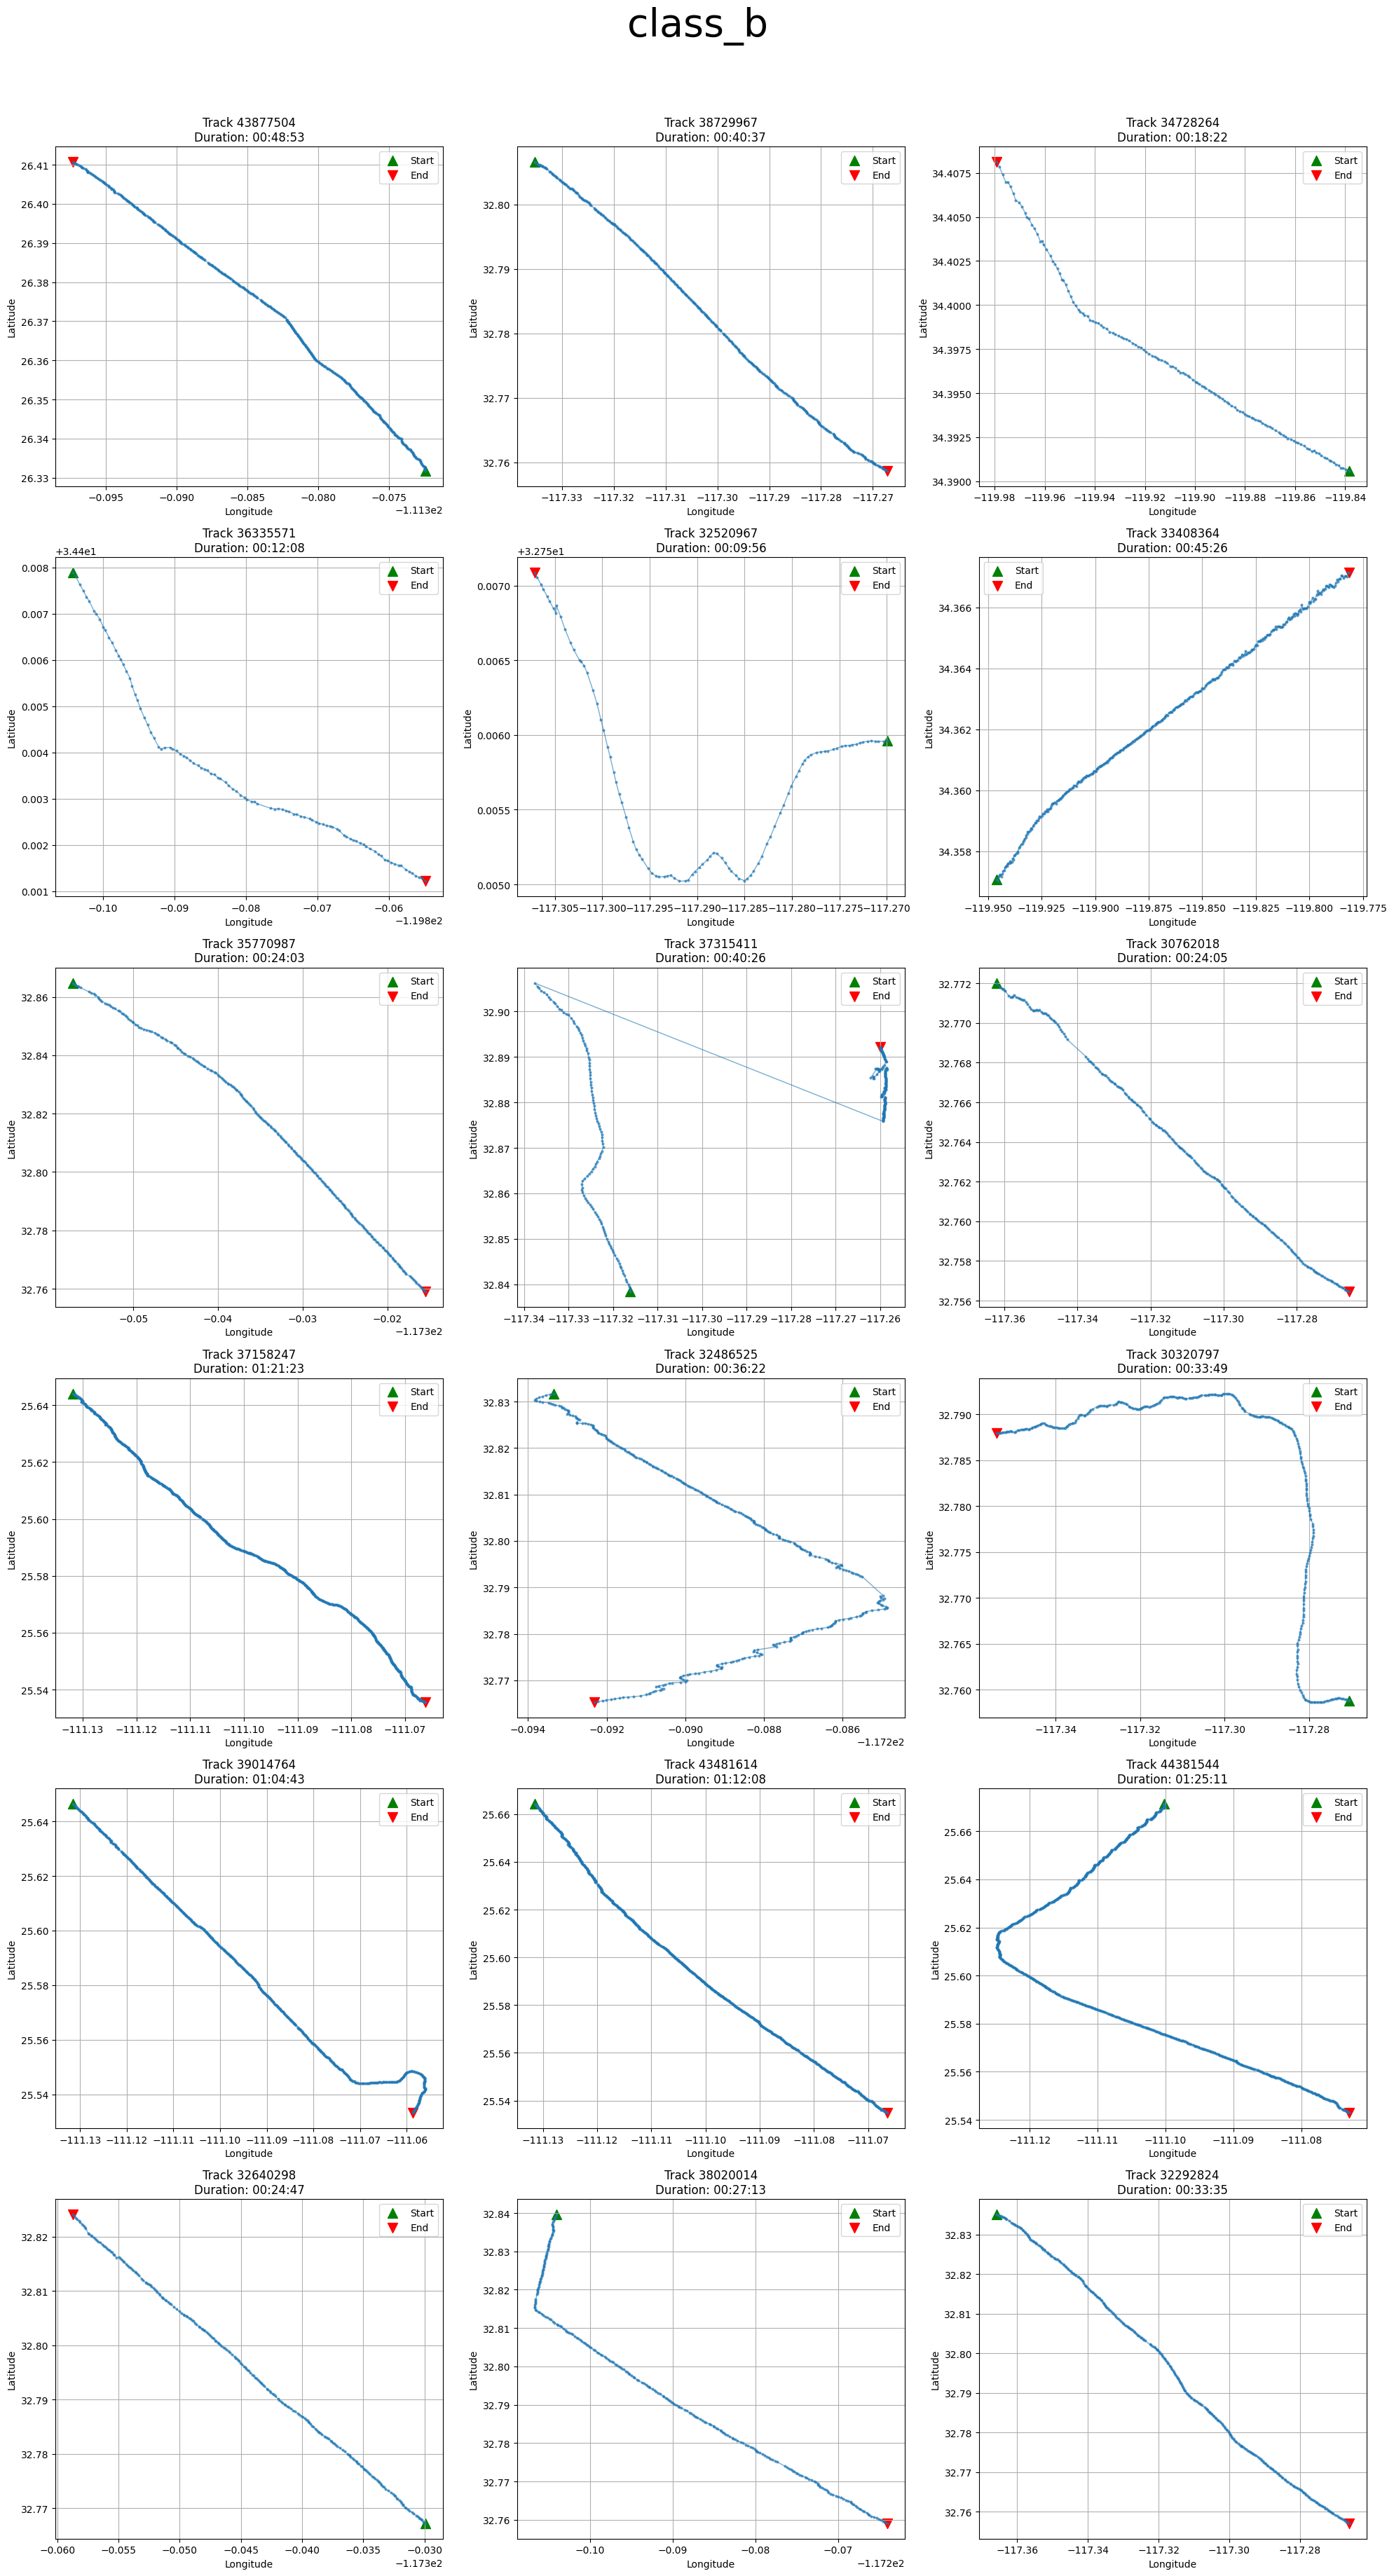

In [60]:
plot_trajectory('class_b', num_samples=18)

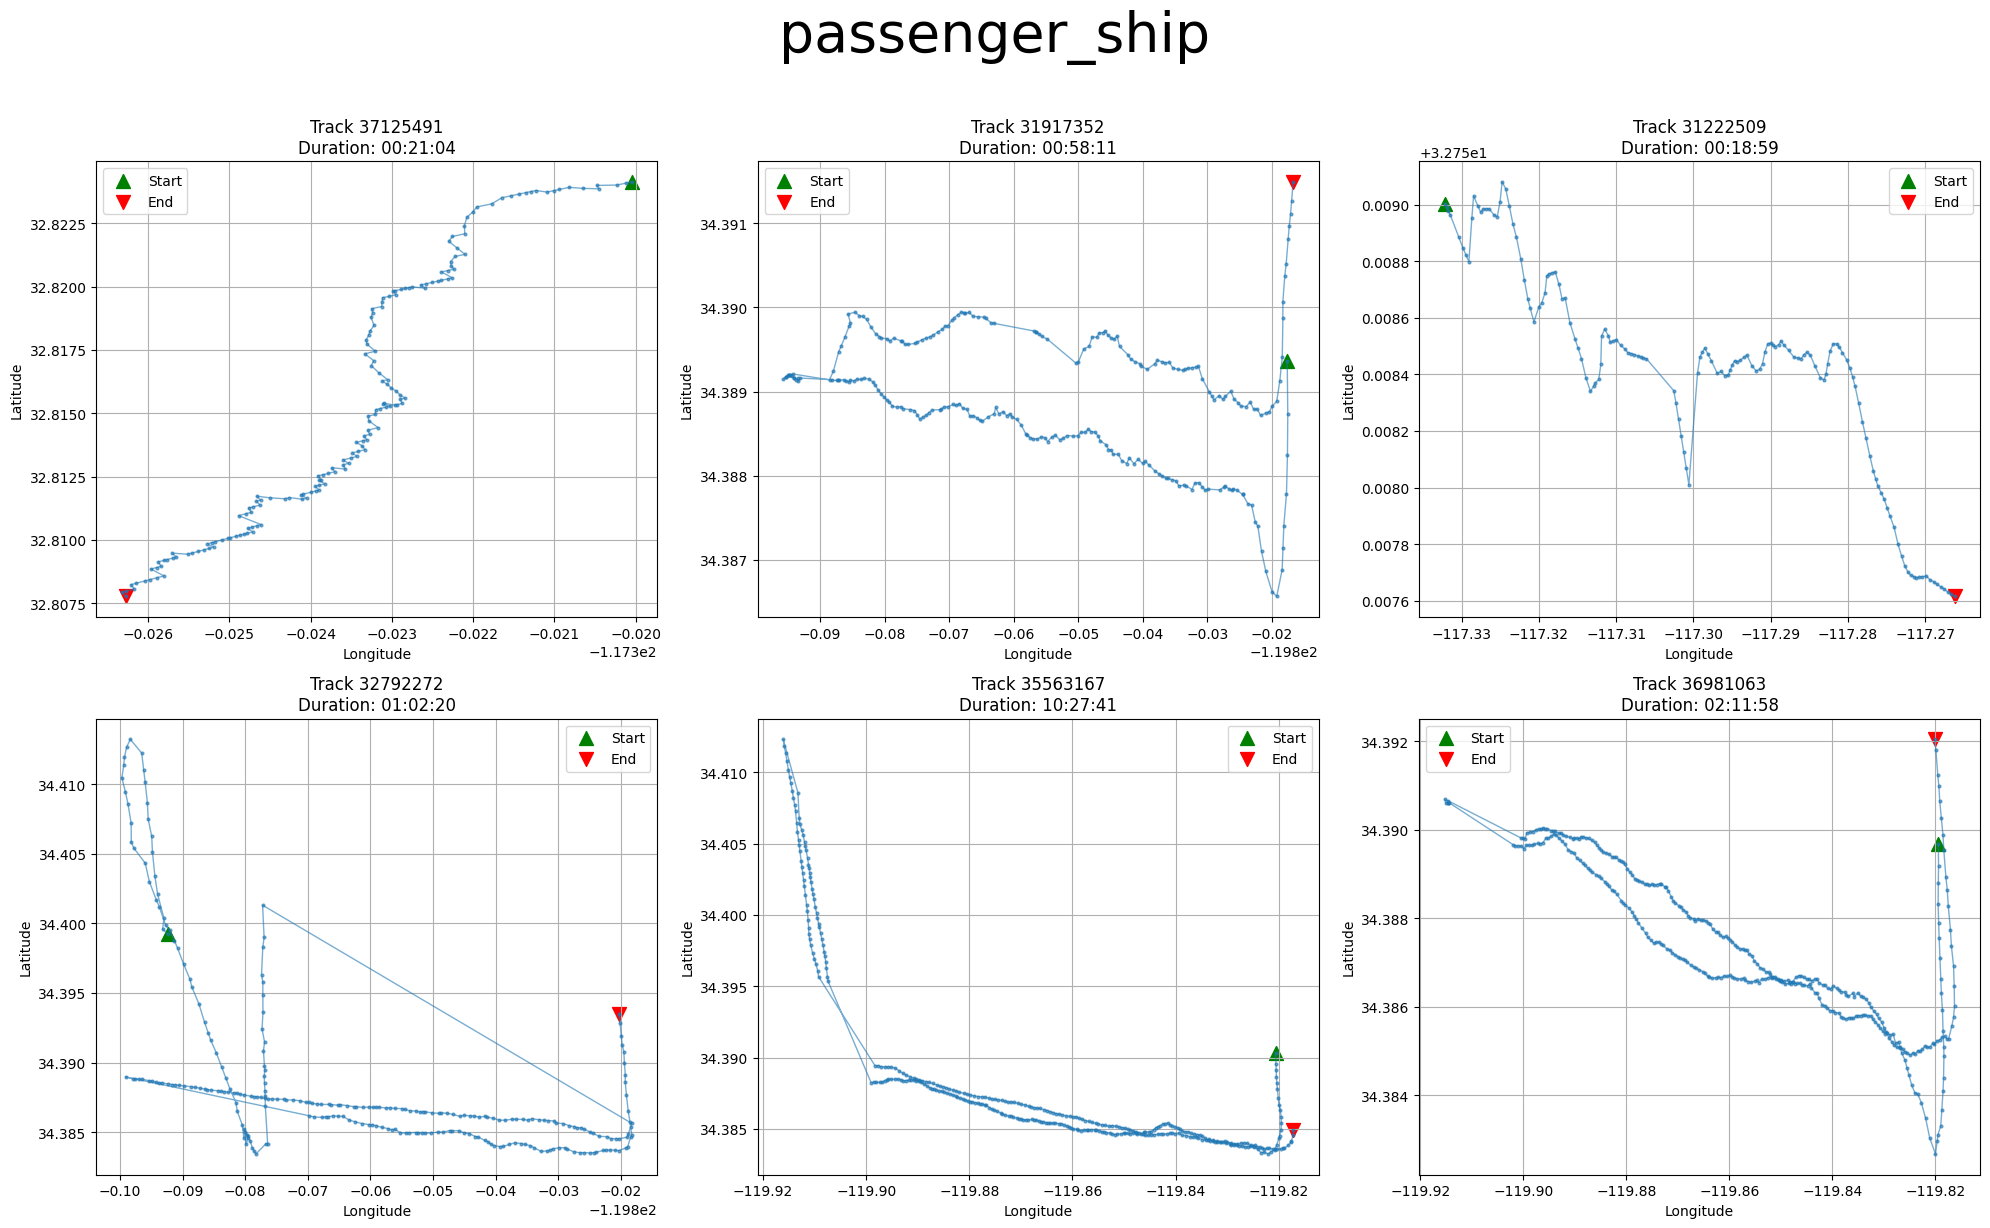

In [61]:
plot_trajectory('passenger_ship')

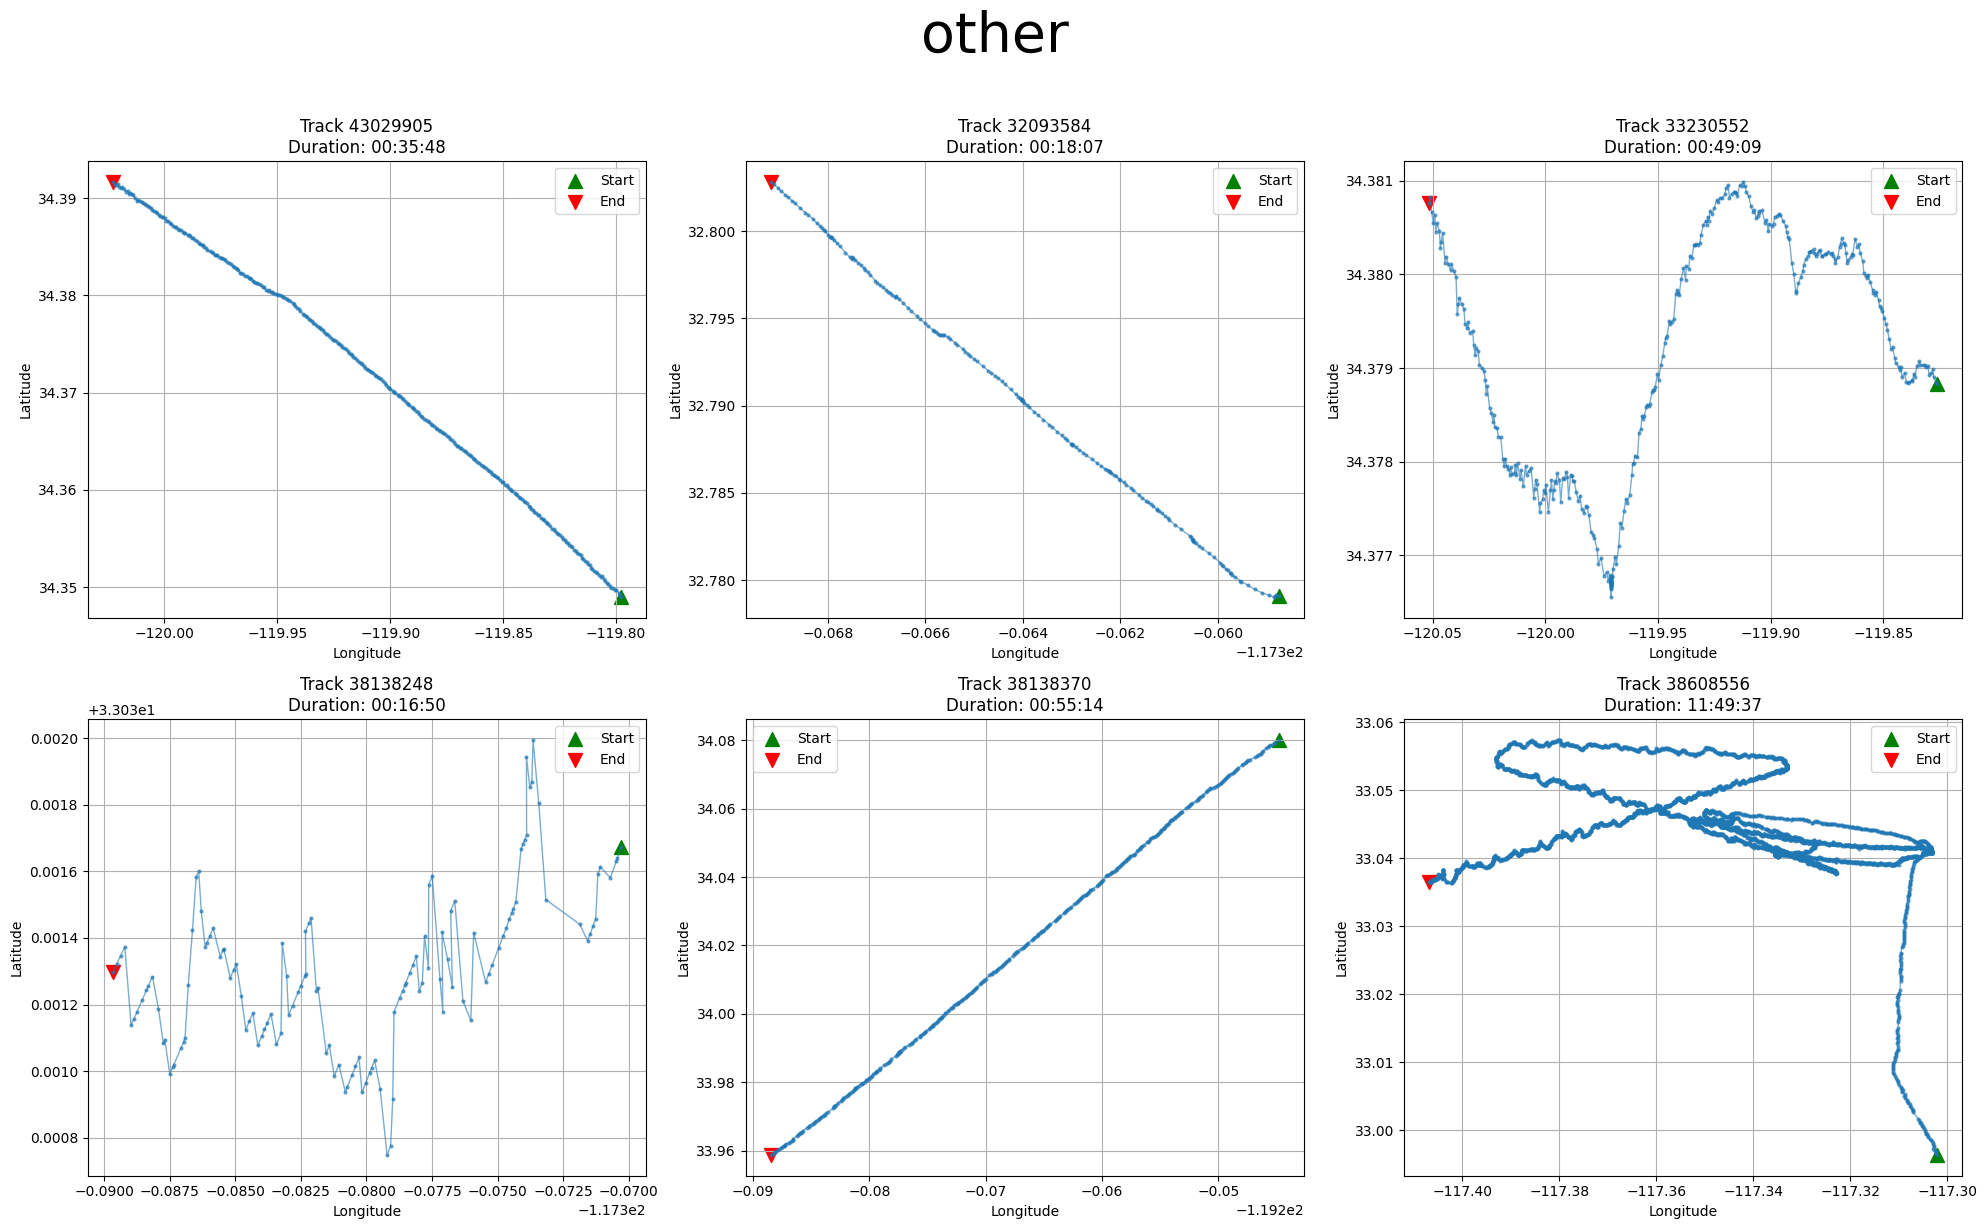

In [62]:
plot_trajectory('other')

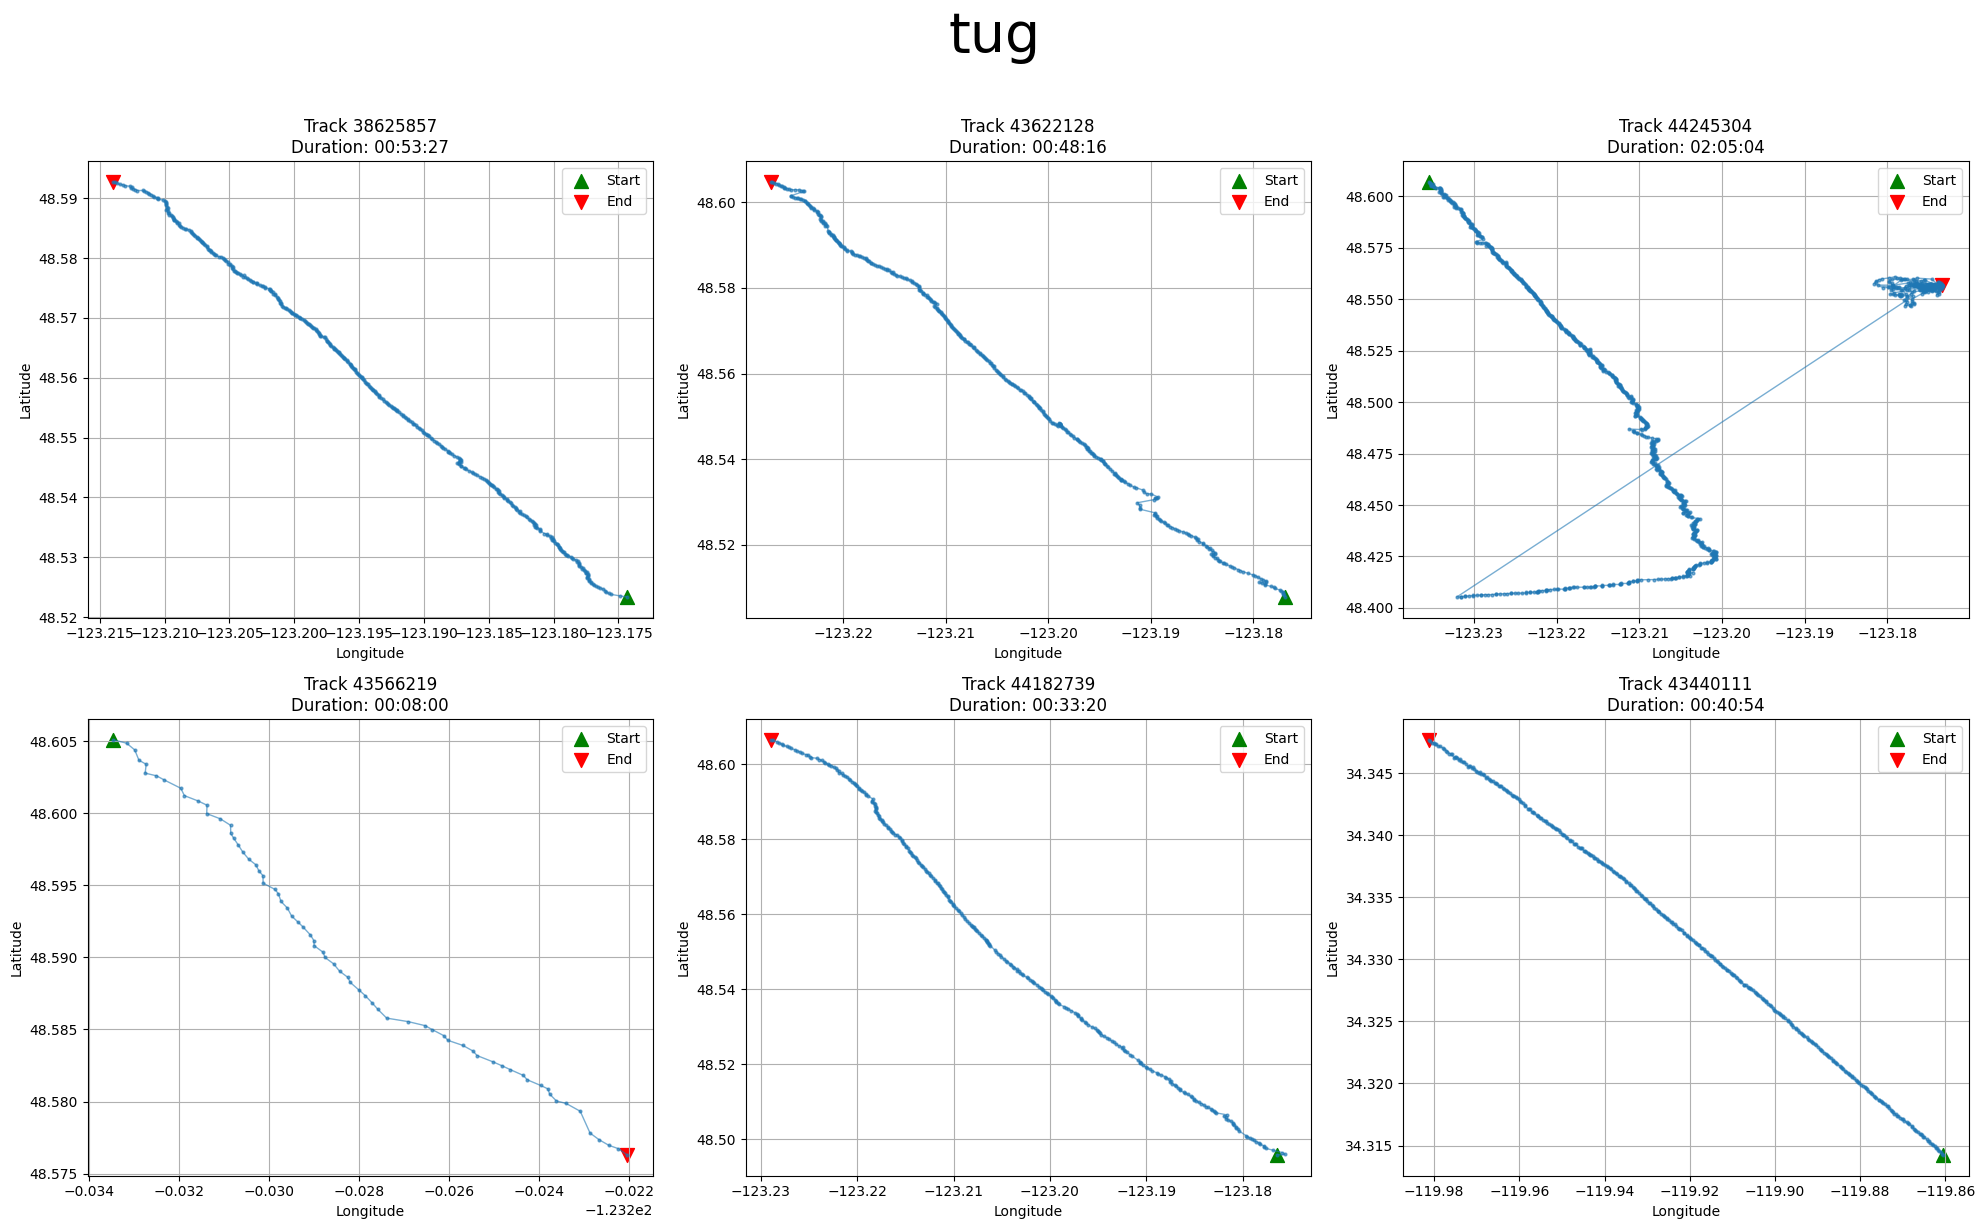

In [64]:
plot_trajectory('tug')

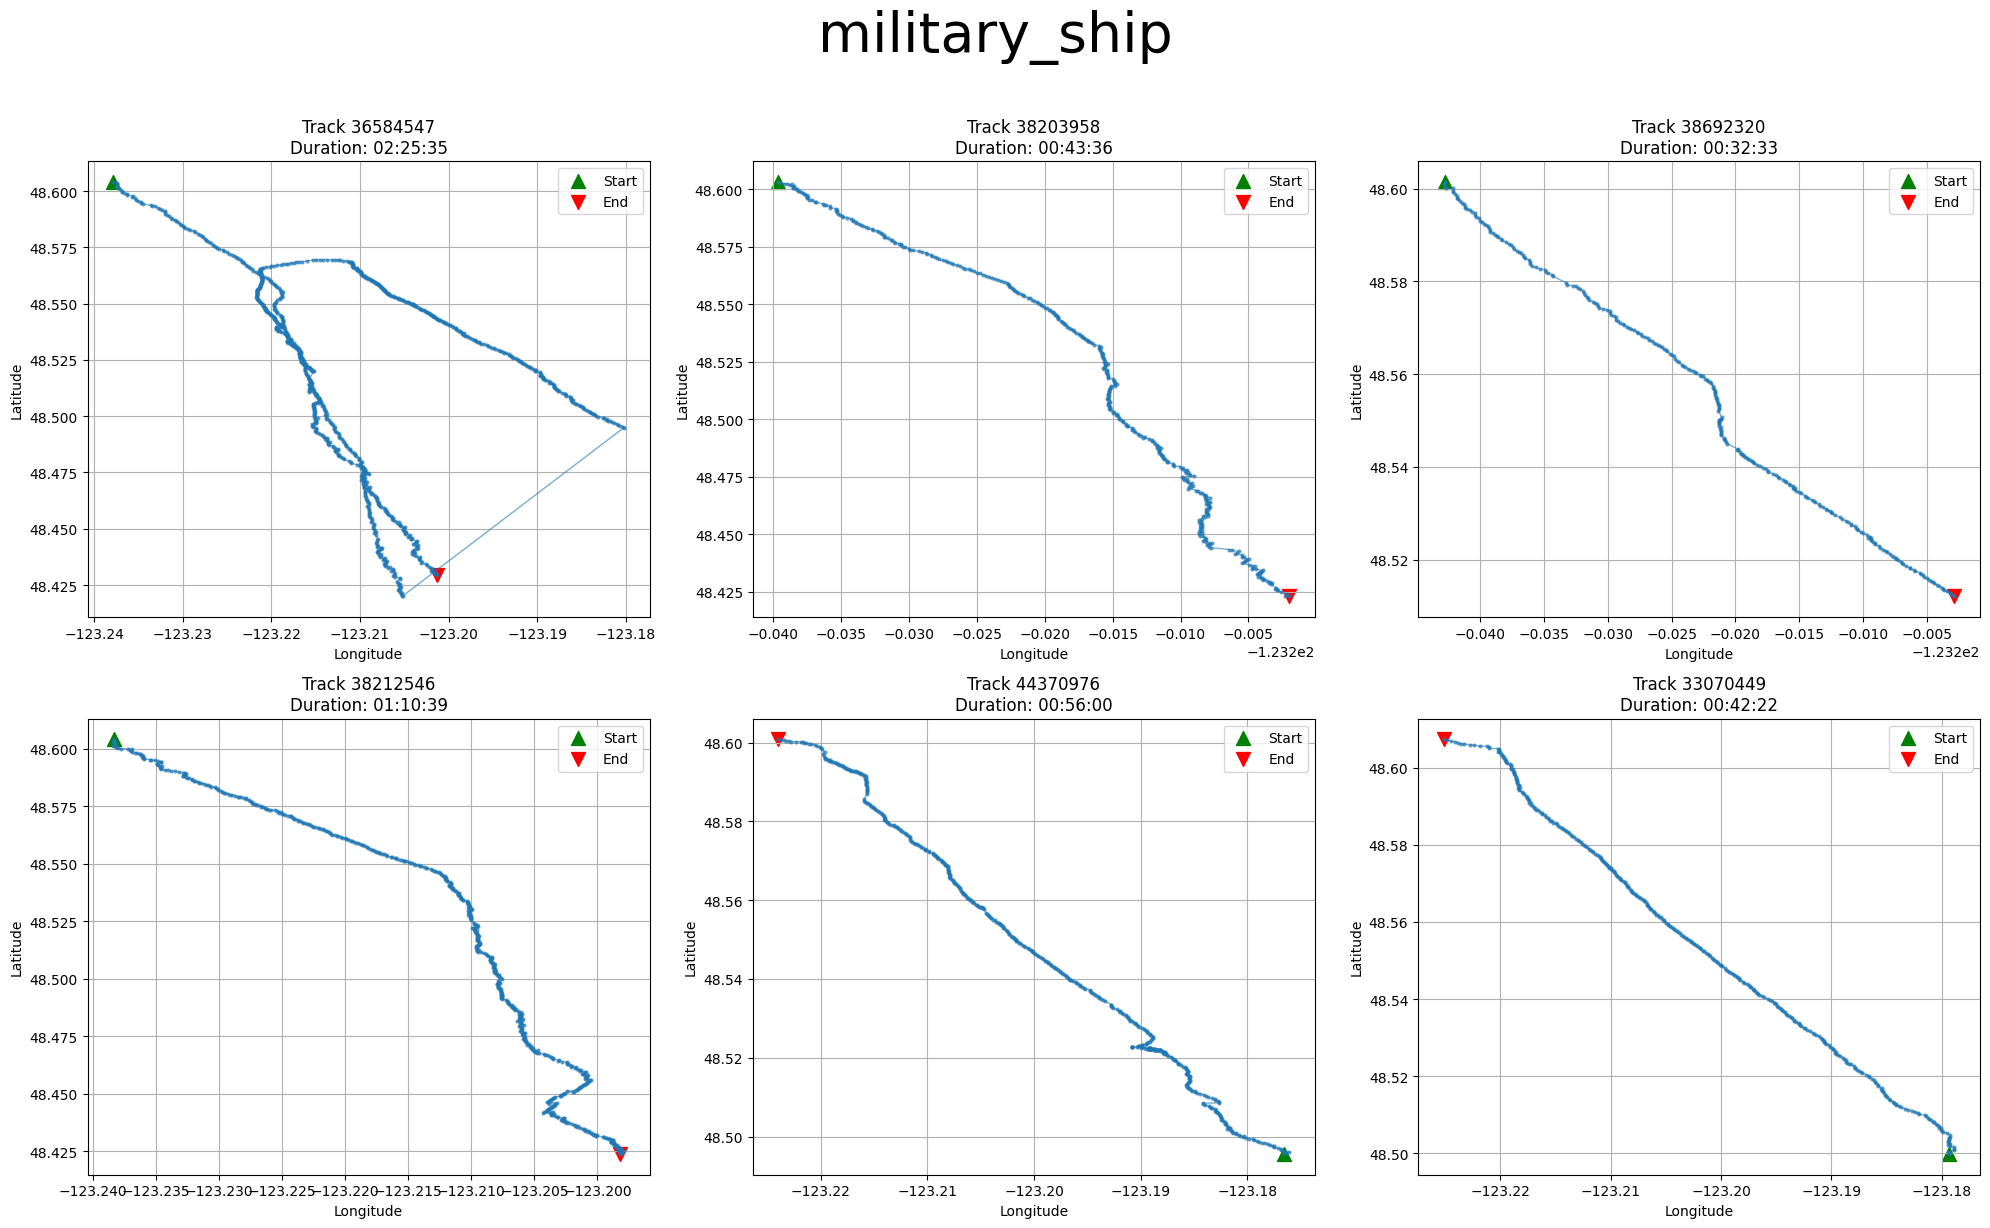

In [65]:
plot_trajectory('military_ship')

### Tagged Detections

In [69]:
# Define columns to check for value 1
activity_columns = ['transit', 'overnight', 'loiter', 'cleanup', 'fishing_c', 
                    'fishing_r', 'research', 'diving', 'repairs', 'distress', 'other']

# Create filter conditions
notes_filter = tracks_tagged['notes'].notna()
activity_filter = tracks_tagged[activity_columns].any(axis=1)

# Apply filters
filtered_tracks = tracks_tagged[notes_filter | activity_filter]

# Display information about the filtering
print("Original number of rows:", len(tracks_tagged))
print("Number of rows after filtering:", len(filtered_tracks))
print("\nBreakdown of filtered rows:")
print("Rows with notes:", notes_filter.sum())
print("Rows with activity:", activity_filter.sum())
print("Rows with both notes and activity:", (notes_filter & activity_filter).sum())

Original number of rows: 9013
Number of rows after filtering: 1195

Breakdown of filtered rows:
Rows with notes: 1009
Rows with activity: 591
Rows with both notes and activity: 405


Top 20 most common words in notes:
aves            287
fishing         170
lobster         130
and             121
line,           102
recreational    102
hook             99
kayak            92
fishing,         84
line             82
the              76
commercial       75
vessel,          62
track            62
unknown          59
target           57
species          57
disrupted        56
sport            54
no               44
Name: count, dtype: int64


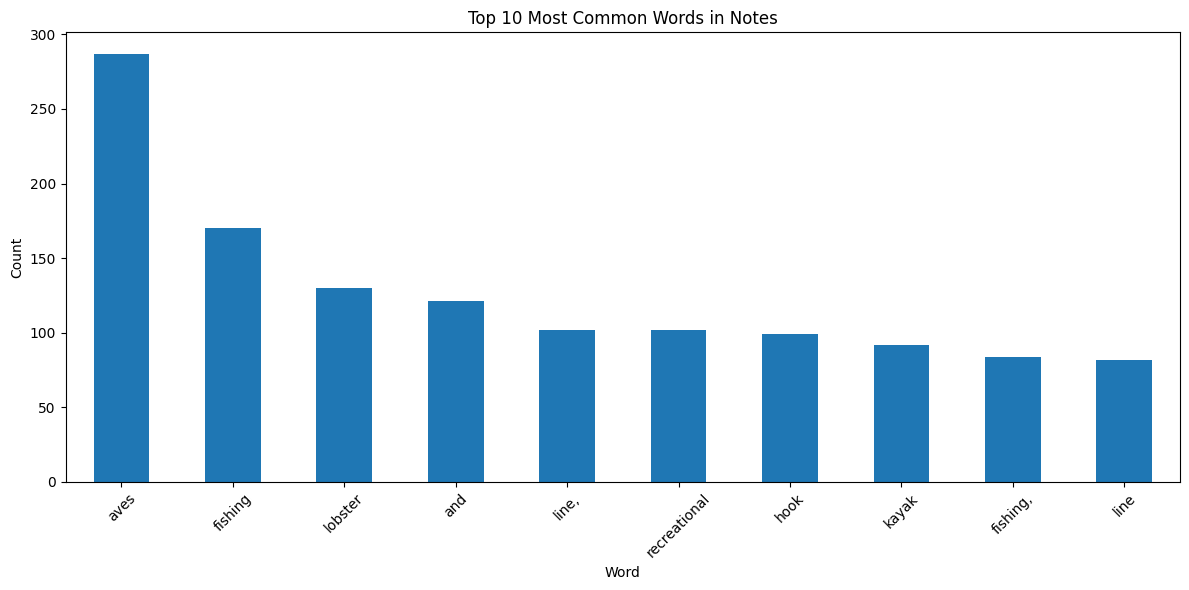

In [72]:
tracks_with_notes = tracks_tagged[notes_filter]

# Convert all notes to lowercase and split into words
all_words = ' '.join(tracks_with_notes['notes'].str.lower()).split()

# Count word frequencies
word_counts = pd.Series(all_words).value_counts()

# Display top 20 most common words
print("Top 20 most common words in notes:")
print(word_counts.head(20))

# Optional: Create a bar plot of top 10 words
plt.figure(figsize=(12, 6))
word_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Common Words in Notes')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
merged_tagged_detections = tagged_detections.merge(
    tracks_with_notes[['id_track', 'notes']],
    on = 'id_track',
    how = 'inner'
)

print('Number of tracks with notes after merging:', len(merged_tagged_detections['id_track'].unique()))

Number of tracks with notes after merging: 1009


In [76]:
lobster_filter = merged_tagged_detections['notes'].str.contains('lobster', case=False, na=False)
lobster_tracks = merged_tagged_detections[lobster_filter]


In [81]:
def plot_trajectory_2(df, title, num_samples = 6):
    """
    Args: 
        type: vessel type of interest
        num_samples: number of random trajectories to be plotted

    Plot trajectories of vessel of type based on radar detections
    """

    df.loc[:, 'datetime'] = df['cdate'] + ' ' + df['ctime']
    track_ids = df['id_track'].unique()
    sampled_tracks = np.random.choice(track_ids, size = num_samples, replace = False)

    # Create subplot grid
    n_rows = num_samples // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(20, 6*n_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Add main title
    fig.suptitle(f'{title}', fontsize=40, y=1.02)

    # Plot each trajectory
    for idx, track_id in enumerate(sampled_tracks):
        track_data = df[df['id_track'] == track_id].sort_values('datetime')
        
        # Calculate duration
        start_time = pd.to_datetime(track_data['ctime'].iloc[0], format='%H:%M:%S')
        end_time = pd.to_datetime(track_data['ctime'].iloc[-1], format='%H:%M:%S')
        duration = end_time - start_time
        hours = duration.components.hours
        minutes = duration.components.minutes
        seconds = duration.components.seconds
        duration_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        
        # Plot trajectory
        axes[idx].plot(track_data['longitude'], track_data['latitude'], 
                      marker='o', markersize=2, linewidth=1, alpha=0.6)
        
        # Add start and end points
        axes[idx].scatter(track_data['longitude'].iloc[0], track_data['latitude'].iloc[0], 
                         color='green', marker='^', s=100, label='Start')
        axes[idx].scatter(track_data['longitude'].iloc[-1], track_data['latitude'].iloc[-1], 
                         color='red', marker='v', s=100, label='End')
        
        # Customize subplot
        axes[idx].set_title(f'Track {track_id}\nDuration: {duration_str}')
        axes[idx].set_xlabel('Longitude')
        axes[idx].set_ylabel('Latitude')
        axes[idx].grid(True)
        axes[idx].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    # # Print information about each track
    # print(f"\nTrajectory Information for {type}:")
    # for track_id in sampled_tracks:
    #     track_data = df[df['id_track'] == track_id]
    #     start_time = pd.to_datetime(track_data['ctime'].iloc[0], format='%H:%M:%S')
    #     end_time = pd.to_datetime(track_data['ctime'].iloc[-1], format='%H:%M:%S')
    #     duration = end_time - start_time
        
    #     print(f"\nTrack {track_id}:")
    #     print(f"Number of points: {len(track_data)}")
    #     print(f"Duration: {duration}")
    #     print(f"Start time: {start_time.strftime('%H:%M:%S')}")
    #     print(f"End time: {end_time.strftime('%H:%M:%S')}")

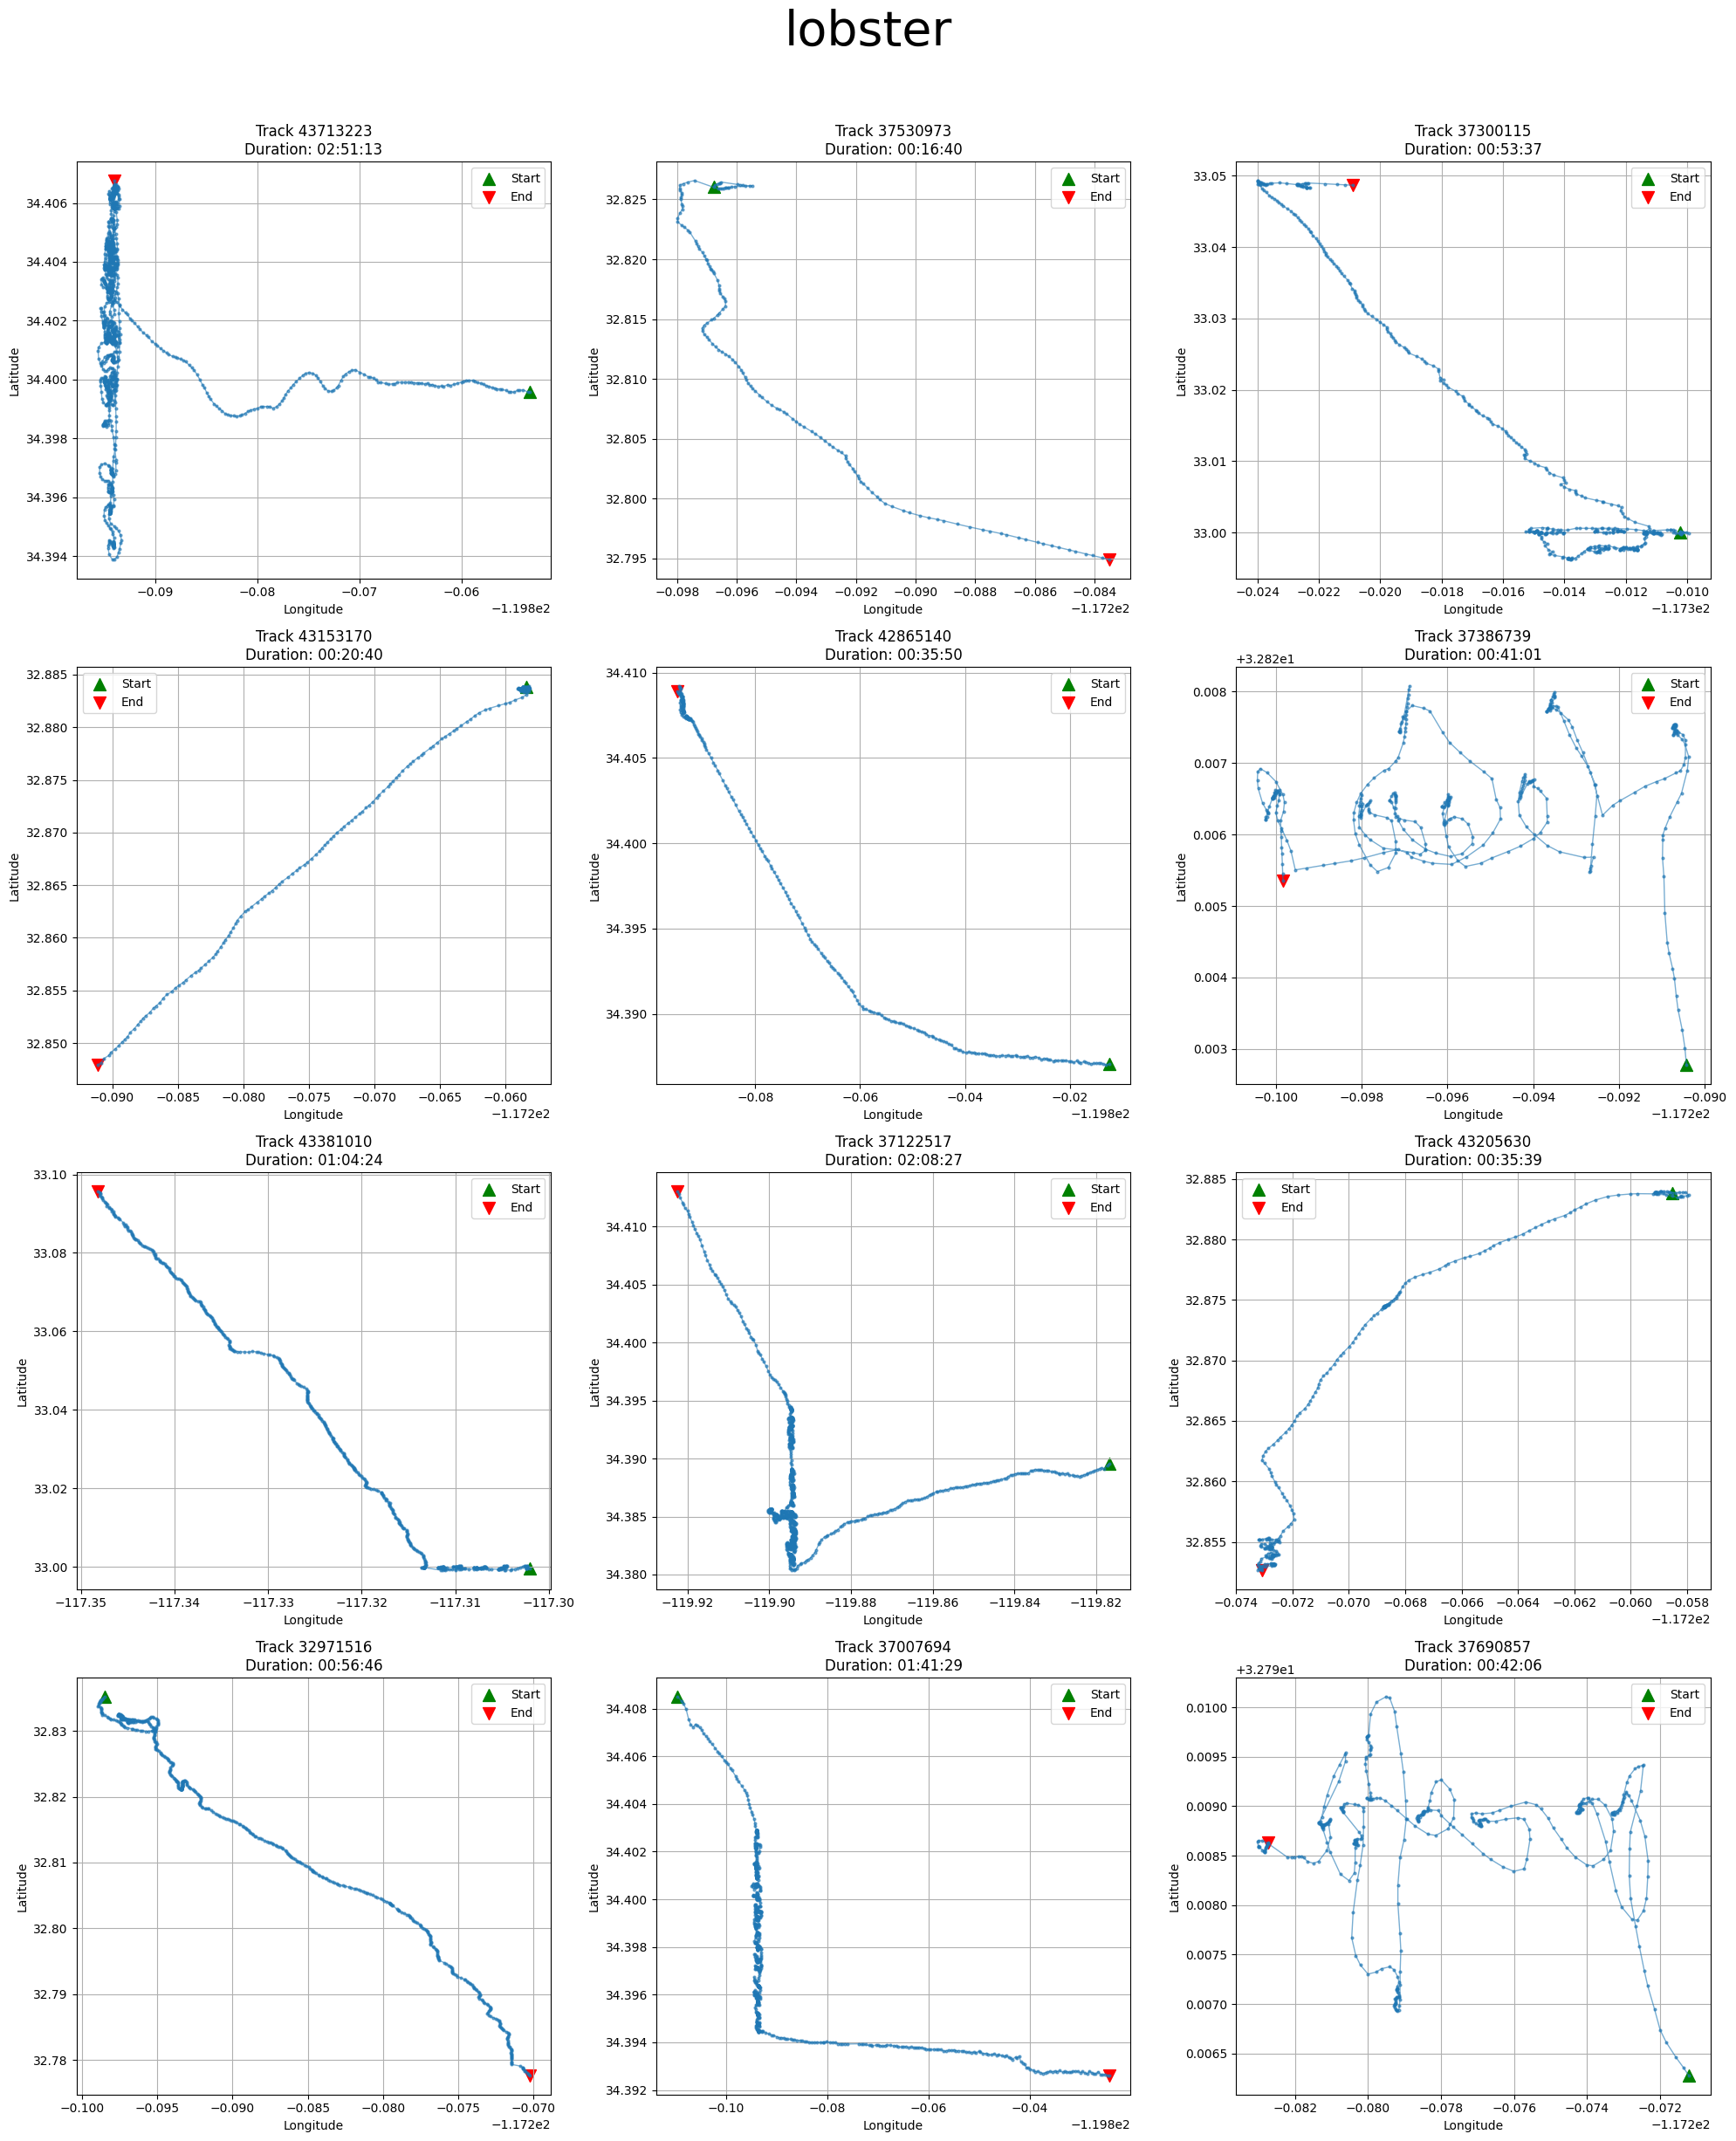

In [83]:
plot_trajectory_2(lobster_tracks, 'lobster', num_samples=12)

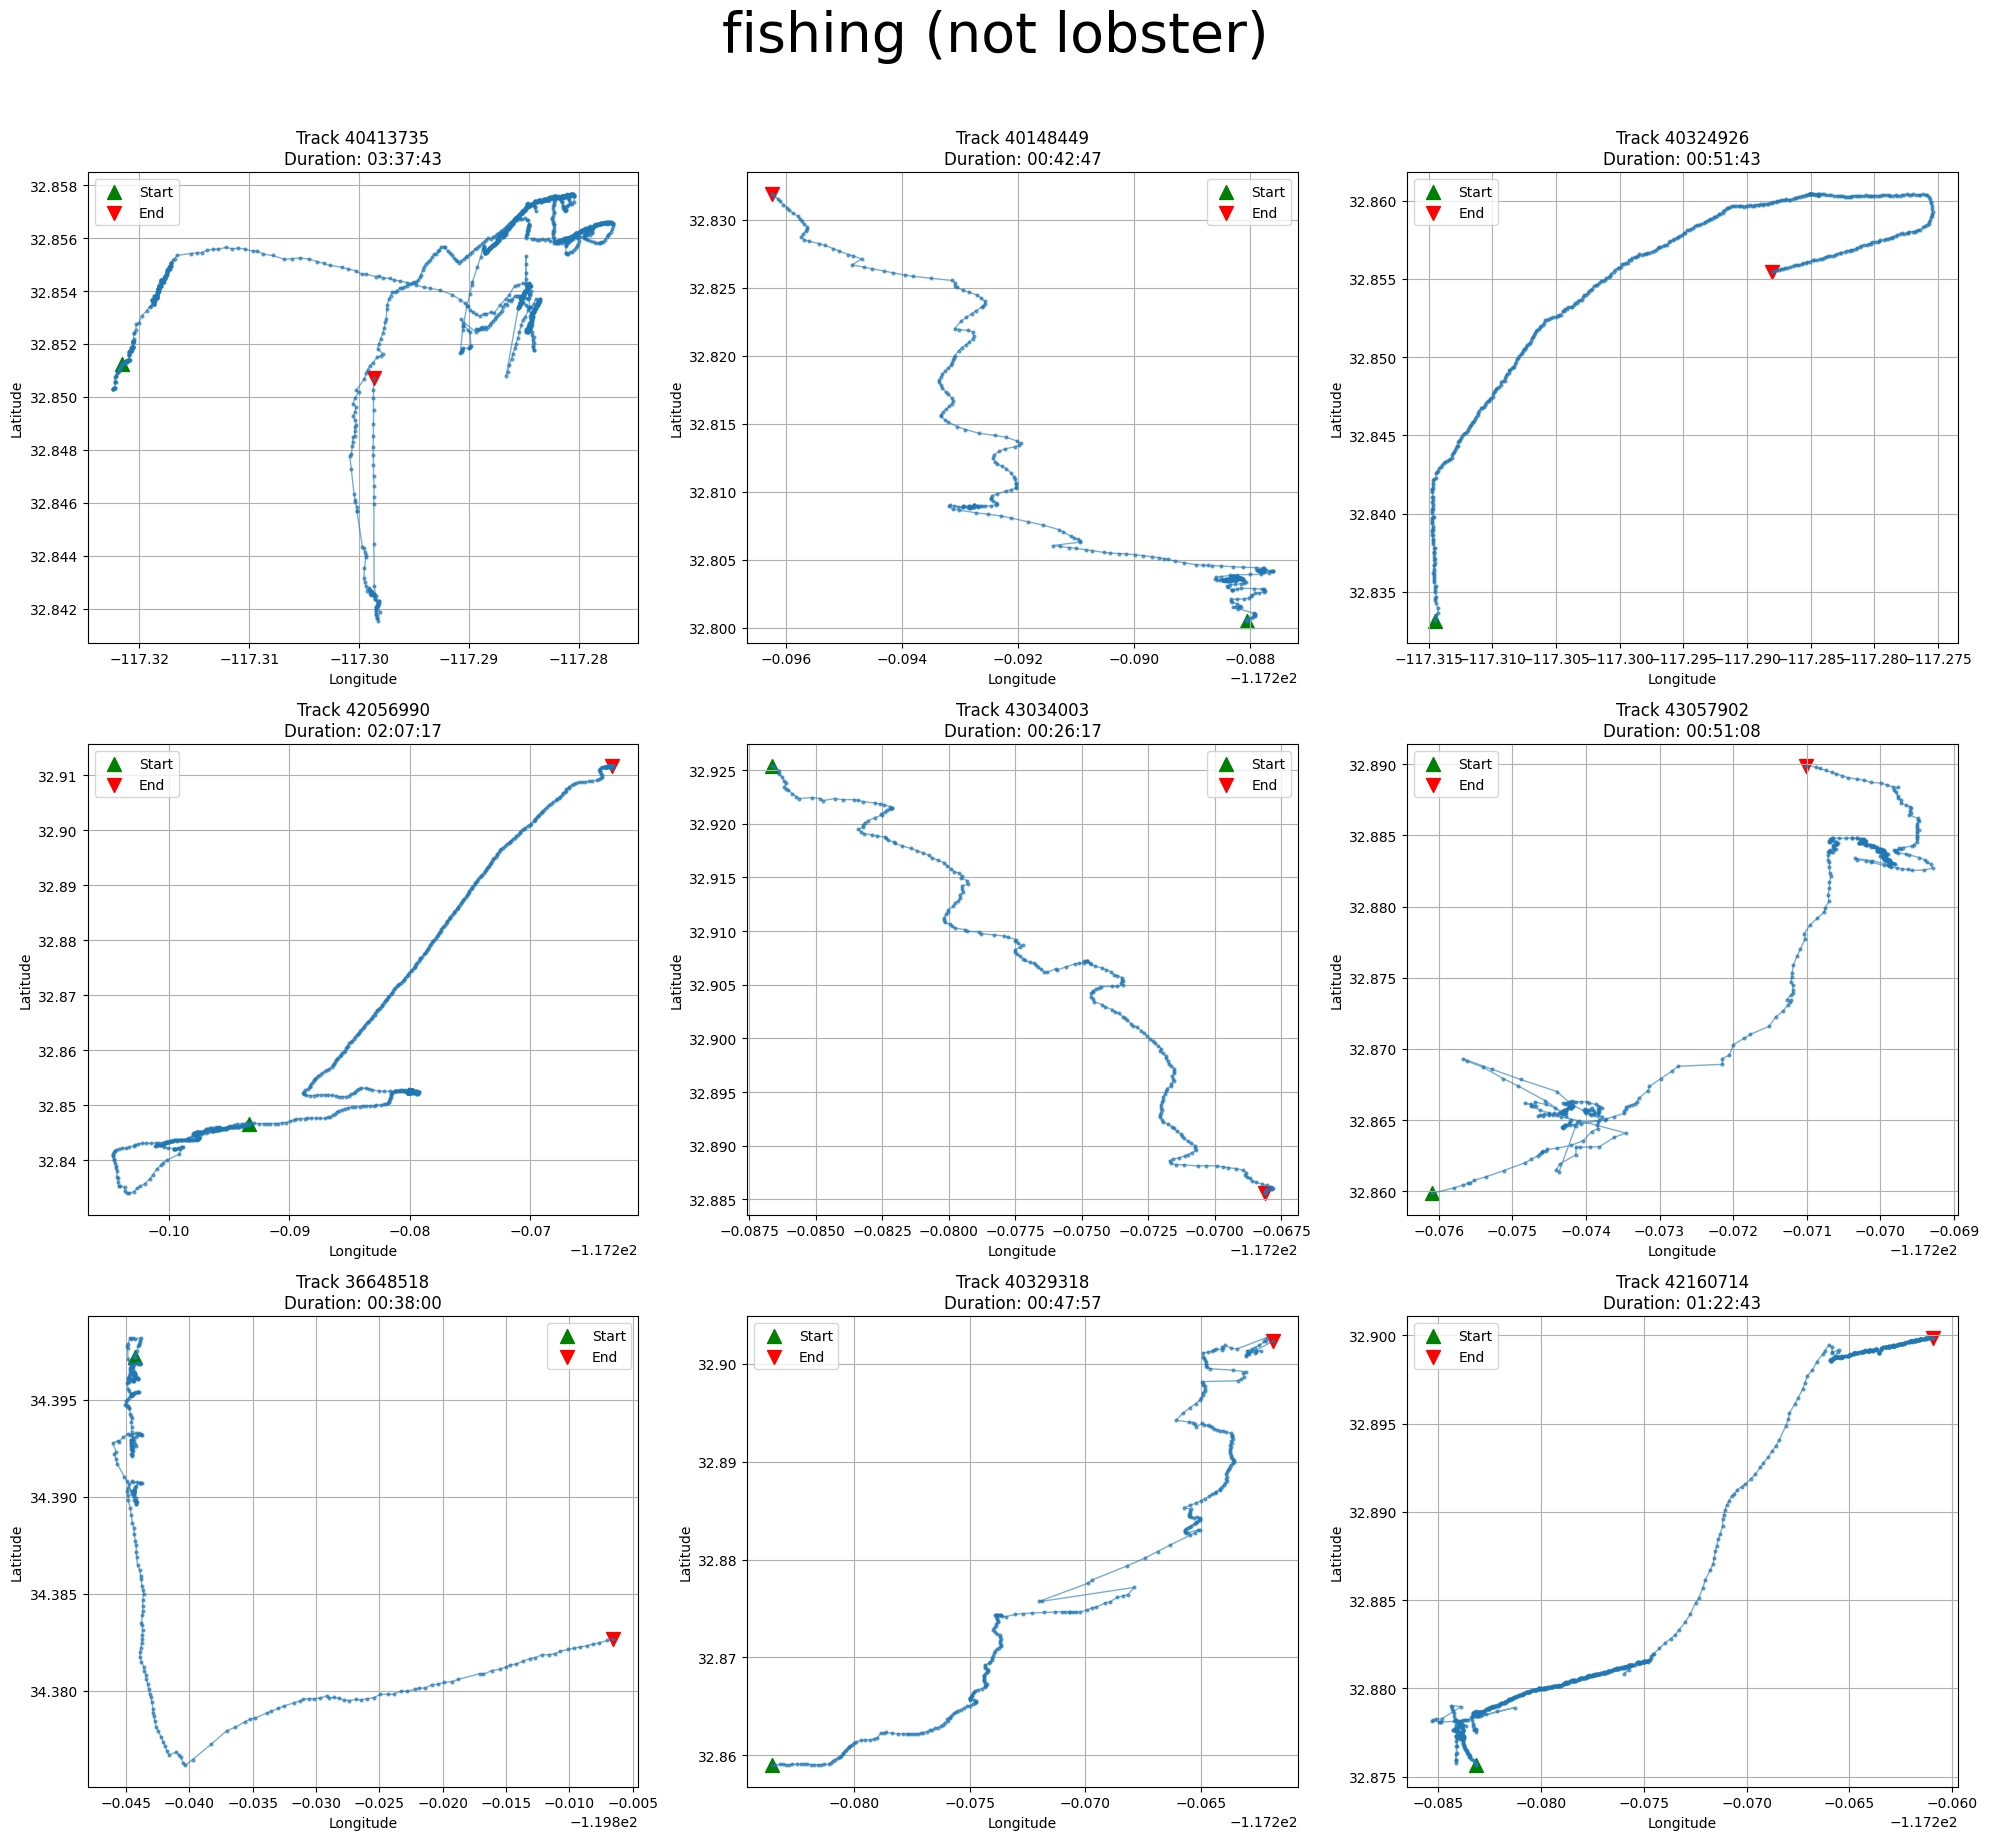

In [86]:
fishing_filter = merged_tagged_detections['notes'].str.contains('fishing', case=False, na=False)
fishing_tracks = merged_tagged_detections[fishing_filter & ~lobster_filter]
plot_trajectory_2(fishing_tracks, 'fishing (not lobster)', 9)